### Optional: Displaying Risk Levels for Departments

The API would utilize the existing dataset (data_final.csv) processed through the defined functions for calculating risk scores.

Possible API-Endpoints: 
    
    1. Risk Information Endpoint  
        Path: /risk-info/{department_code}
        Description: Retrieves risk level and normalized risk score for a specific department based on the current time category.
        Parameters: department_code (str)
        Output: JSON response containing the department code, risk level, and normalized risk score
    
    2. High-Risk Departments Endpoint
        Path: /high-risk-departments
        Description: Returns a list of departments classified as high risk during the current time category.
        Output: JSON response containing department codes, normalized risk scores, and risk levels.
    
    3. Visualization Endpoint
        Path: /visualization
        Description: Generates and returns a visualization of risk levels by department.
        Output: An HTML response embedding the generated visualization image, allowing users to view the risk levels directly in their browser.

In [2]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import geopandas as gpd
import warnings

#Suppress all warnings
warnings.filterwarnings('ignore')

#### Data preparation

In [3]:
#Read dataset
df = pd.read_csv('src/data/final/data_final.csv', encoding='ISO-8859-1')

In [5]:
#Format department codes to match geojson codes
def format_department_code(code):
    """
    Formats department codes based on specified rules.

    Parameters:
    - code (int): The department code to format.

    Returns:
    - str or None: The formatted department code as a string, or None if no specific formatting rule applies.
    
    Formatting rules:
    - If the code is 201, return '2A'.
    - If the code is 202, return '2B'.
    - If the code is a multiple of 10 and at least 10, return the code divided by 10 as a two-digit string (e.g., 50 becomes '05').
    - For all other codes, return None.
    """
    if code == 201:
        return '2A'
    elif code == 202:
        return '2B'
    elif code >= 10 and code % 10 == 0:
        return f'{code // 10:02d}'
    return None

In [6]:
#Apply department code formatting
df['Department_Code'] = df['Department_Code'].apply(format_department_code)
df_filtered = df[df['Department_Code'].notna()]

In [7]:
#Read GeoJSON
geojson_path = 'src/data/contour-des-departements.geojson'
map_df = gpd.read_file(geojson_path)

#### Calculation of risk scores and risk levels

In [8]:
#Calculate risk scores
def calculate_risk_scores(data):
    """
    Calculates and normalizes risk scores for accidents based on severity and frequency,
    and classifies them into risk levels.
    
    Parameters:
    data (DataFrame): A DataFrame containing accident data with columns.
    
    Returns:
    DataFrame: A DataFrame with normalized risk scores and risk levels for each
               department and time of day combination.
    """
    risk_scores = (data.groupby(['Department_Code', 'Time_of_Day'])
                   .agg(avg_severity=('Severity', 'mean'),
                       total_accidents=('Severity', 'count'))
                   .reset_index())
    
    risk_scores['risk_score'] = risk_scores['avg_severity'] * risk_scores['total_accidents']

    risk_scores['normalized_risk_score'] = ((risk_scores['risk_score'] - risk_scores['risk_score'].min()) /
                                              (risk_scores['risk_score'].max() - risk_scores['risk_score'].min())) * 100
    
    risk_scores['normalized_risk_score'] = risk_scores['normalized_risk_score'].astype(int)
    
    risk_scores['risk_level'] = pd.cut(risk_scores['normalized_risk_score'], bins=[-float('inf'), 10, 20, float('inf')],
                                        labels=['Low', 'Medium', 'High'], right=False)
    
    return risk_scores

#### Retrieving risk information

In [9]:
def get_current_time_category():
    current_hour = datetime.now().hour
    return (current_hour // 6) % 4  # Returns 0, 1, 2, or 3 based on the current hour

In [10]:
def get_risk_info(risk_scores, department_code):
    """
    Retrieves risk level and normalized risk score for a specific department,
    considering the current time category.

    Parameters:
    - risk_scores (DataFrame): A DataFrame containing risk scores with columns for department codes,
      normalized risk scores, and risk levels.
    - department_code (str): The department code for which to retrieve risk information.

    Returns:
    - dict: A dictionary containing the risk level and normalized risk score for the specified department
      based on the current time category.
    """
    current_time_category = get_current_time_category()
    
    department_info = risk_scores[
        (risk_scores['Department_Code'] == department_code) &
        (risk_scores['Time_of_Day'] == current_time_category)
    ]
    
    if not department_info.empty:
        return {
            'Department_Code': department_code,
            'Risk_Level': department_info['risk_level'].values[0],
            'Normalized_Risk_Score': department_info['normalized_risk_score'].values[0]
        }
    else:
        return {
            'Department_Code': department_code,
            'Risk_Level': None,
            'Normalized_Risk_Score': None
        }

In [11]:
def get_high_risk_departments_with_time_category(risk_scores):
    """
    Filters high-risk departments based on the current time category.

    Parameters:
    - risk_scores (DataFrame): A DataFrame containing risk scores with columns for department codes, 
      normalized risk scores, risk levels, and time of day.

    Returns:
    - DataFrame: A DataFrame containing department codes, normalized risk scores, and risk levels 
      for departments classified as 'High' risk during the current time category.

    The function determines the current time category using the `get_current_time_category` function 
    and filters the input DataFrame to return only those rows where the risk level is 'High' 
    and the time of day matches the current time category.
    """
    current_time_category = get_current_time_category()
    return risk_scores[(risk_scores['risk_level'] == 'High') & 
                       (risk_scores['Time_of_Day'] == current_time_category)][['Department_Code', 'normalized_risk_score', 'risk_level']]

#### Visualization - Risk Level Map

In [ ]:
def visualize_risk_levels(merged_df, title="Risk Levels by Department"):
    """
    Visualizes risk levels by department using a map and adds department codes as labels.
    
    Parameters:
    - merged_df (GeoDataFrame): A GeoDataFrame containing the merged department and risk information.
    - title (str): Title of the plot.
    """
    merged_df['risk_level'] = pd.Categorical(merged_df['risk_level'], categories=['Low', 'Medium', 'High'], ordered=True)

    color_map = {
        'Low': 'green',
        'Medium': 'yellow',
        'High': 'red'
    }
    
    merged_df['color'] = merged_df['risk_level'].map(color_map)

    with plt.style.context('seaborn-v0_8-dark'):
        fig, ax = plt.subplots(1, 1, figsize=(15, 15))
        
        #Plot the geometries with the color mapped to risk levels
        merged_df.boundary.plot(ax=ax, color='black', linewidth=0.5)
        merged_df.plot(ax=ax, color=merged_df['color'], legend=False)

        #Adding department codes as labels
        for centroid, label in zip(merged_df.geometry.centroid, merged_df['Department_Code']):
            ax.text(centroid.x, centroid.y, label, fontsize=8, ha='center', color='black', weight='bold')

        #Adding title and axis
        ax.set_title(title, fontsize=18)
        ax.set_axis_off()

        #Create custom legend
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[level], markersize=12) 
                   for level in color_map.keys()]
        ax.legend(handles, color_map.keys(), title="Risk Levels", loc='upper right', fontsize=12, title_fontsize=14)

        #Show plot
        plt.show()

High-Risk Departments:
     Department_Code  normalized_risk_score risk_level
23               06                     25       High
51               13                     48       High
135              33                     23       High
239              59                     22       High
279              69                     25       High
303              75                     78       High
371              92                     30       High
375              93                     33       High
379              94                     29       High
Risk Info for Department: {'Department_Code': '01', 'Risk_Level': 'Low', 'Normalized_Risk_Score': np.int64(5)}


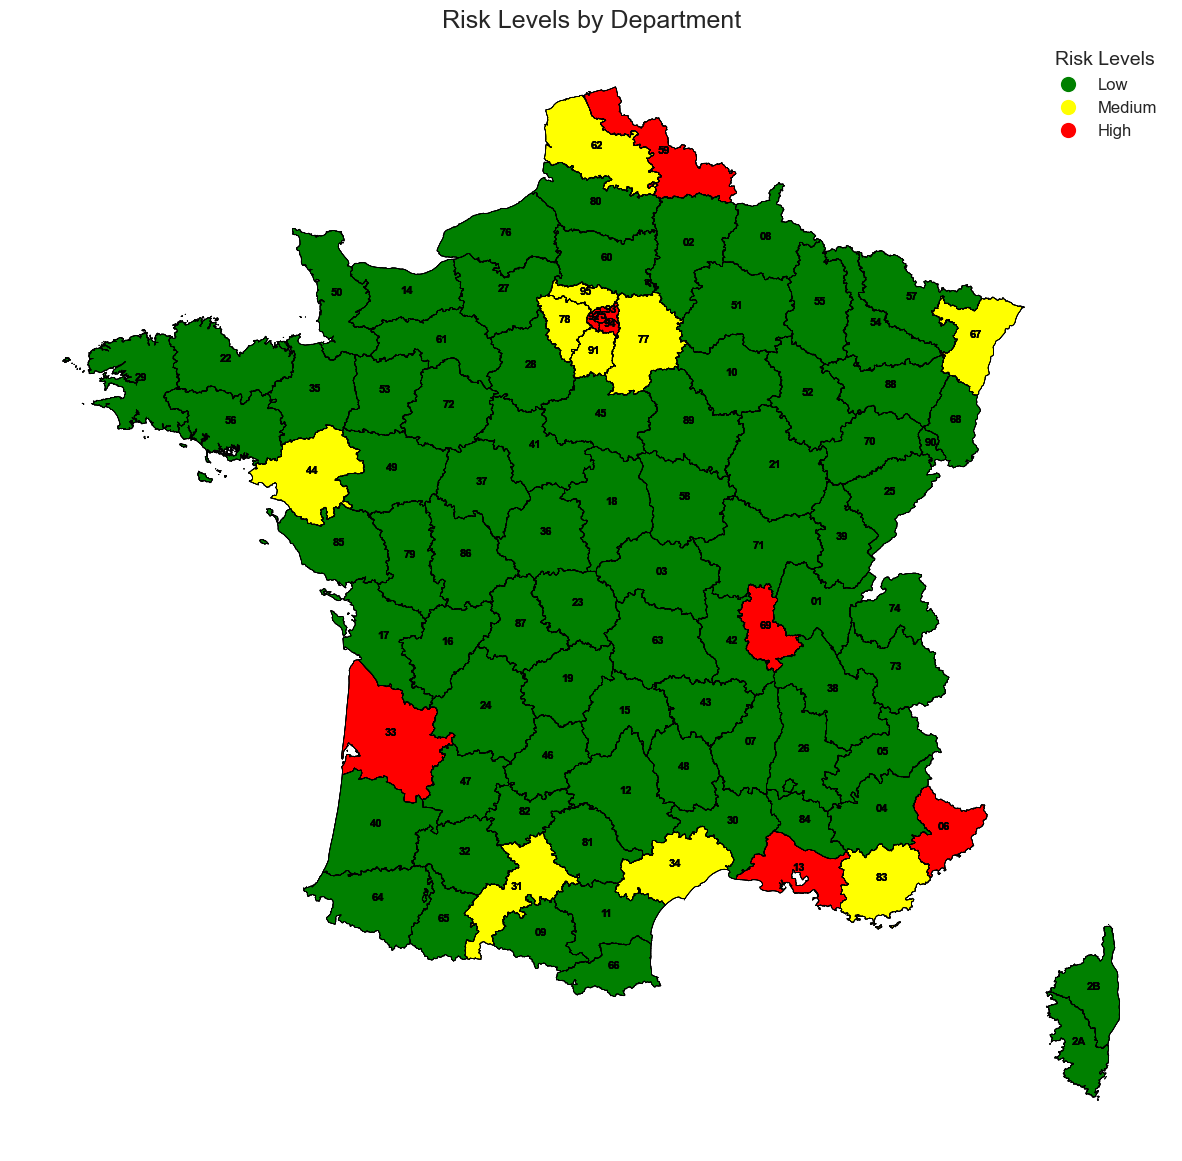

In [26]:
#Get risk scores
risk_scores_df = calculate_risk_scores(df_filtered)

#Get high-risk departments for the current time category
high_risk_departments_df = get_high_risk_departments_with_time_category(risk_scores_df)
print("High-Risk Departments:\n", high_risk_departments_df)

#Specify the department code you want to check
department_code = '01'

#Get risk information for the specified department
risk_info = get_risk_info(risk_scores_df, department_code)
print("Risk Info for Department:", risk_info)

#Merge GeoDataFrame with risk scores
merged_df = map_df.merge(risk_scores_df, left_on='code', right_on='Department_Code', how='left')

#Visualize the risk levels on the map
visualize_risk_levels(merged_df)